# Projeto: Análise do Mercado Imobiliário em Lisboa com Dados do Airbnb

Este projeto tem como objetivo explorar e analisar dados públicos de imóveis disponíveis no Airbnb na cidade de Lisboa. Por meio de técnicas de análise exploratória de dados (EDA) e visualizações, buscamos identificar padrões de preços, tipos de acomodações, regiões com maior disponibilidade e insights que ajudem a entender melhor o mercado de aluguel de curto prazo na cidade.

**Autor:** Lisandro Almeida Viana

🔍 **Problemas que este projeto ajuda a responder:**
- Qual o preço médio dos imóveis por tipo de acomodação?
- Quais são os bairros com maior oferta de imóveis e disponibilidade?
- Quais fatores influenciam mais no preço de um imóvel no Airbnb?
- Como um novo anunciante pode se posicionar melhor no mercado?
- É possível prever o preço de um imóvel com base em suas características?

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## 🎯 Objetivo da Análise
- Entender a distribuição de preços dos imóveis
- Comparar valores por tipo de acomodação
- Avaliar a disponibilidade por região
- Identificar bairros com maior oferta

In [28]:
df = pd.read_csv('/Projects/Portifolio/airbnb-lisboa-analise/listings_amostra.csv')

In [29]:
colunas = [
    'name', 'neighbourhood_cleansed', 'latitude', 'longitude',
    'room_type', 'price', 'minimum_nights', 'availability_365',
    'number_of_reviews', 'review_scores_rating']
df = df[colunas]

In [30]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df.dropna(inplace=True)
df = df[(df['price'] > 0) & (df['minimum_nights'] < 365)]

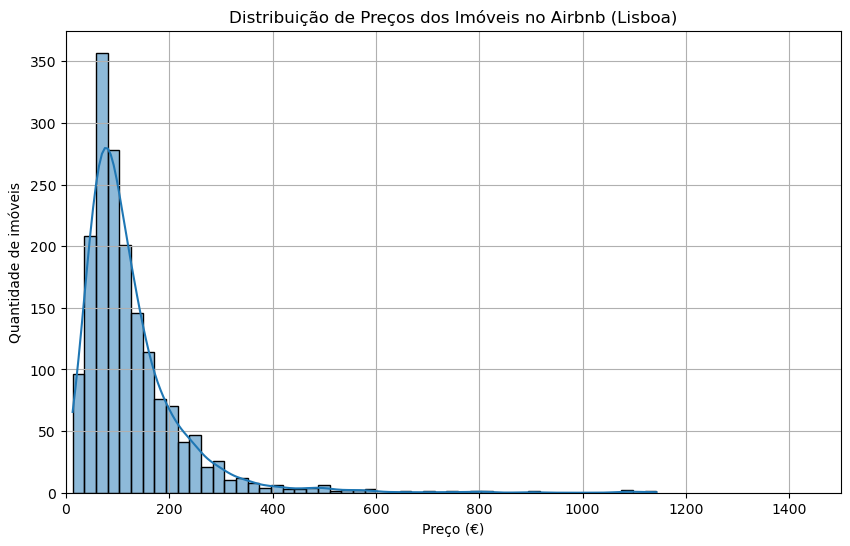

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribuição de Preços dos Imóveis no Airbnb (Lisboa)')
plt.xlabel('Preço (€)')
plt.ylabel('Quantidade de imóveis')
plt.xlim(0, 1500)
plt.grid(True)
plt.show()

**Distribuição de Preços:** a grande maioria das diárias está abaixo de €1500, com alguns outliers representando imóveis de luxo.

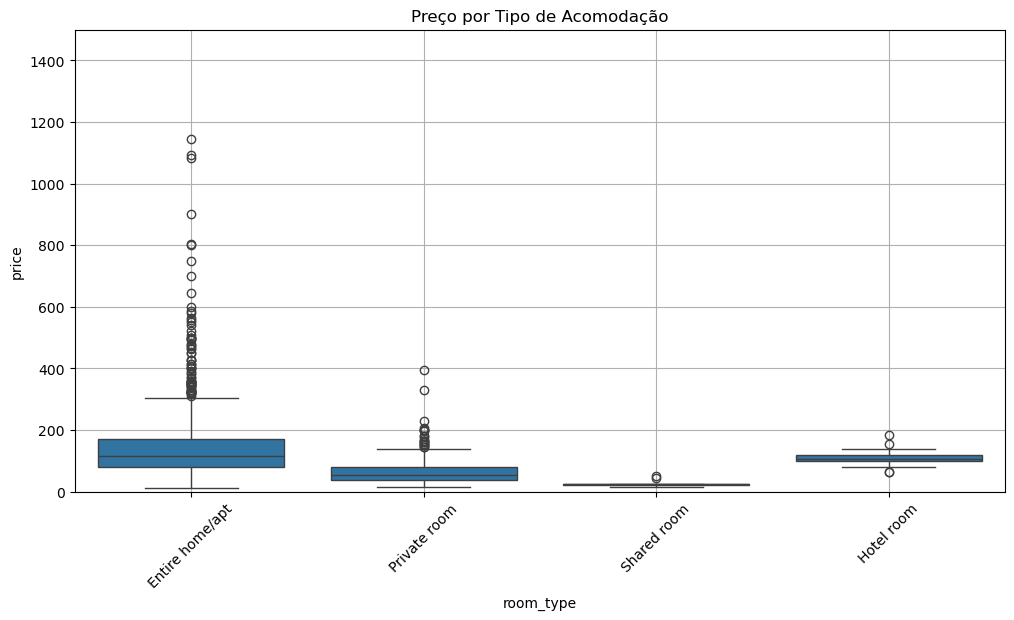

In [32]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Preço por Tipo de Acomodação')
plt.xticks(rotation=45)
plt.ylim(0, 1500)
plt.grid(True)
plt.show()

**Tipos de Acomodações:** apartamentos inteiros têm preços médios bem mais altos que quartos privados ou compartilhados.

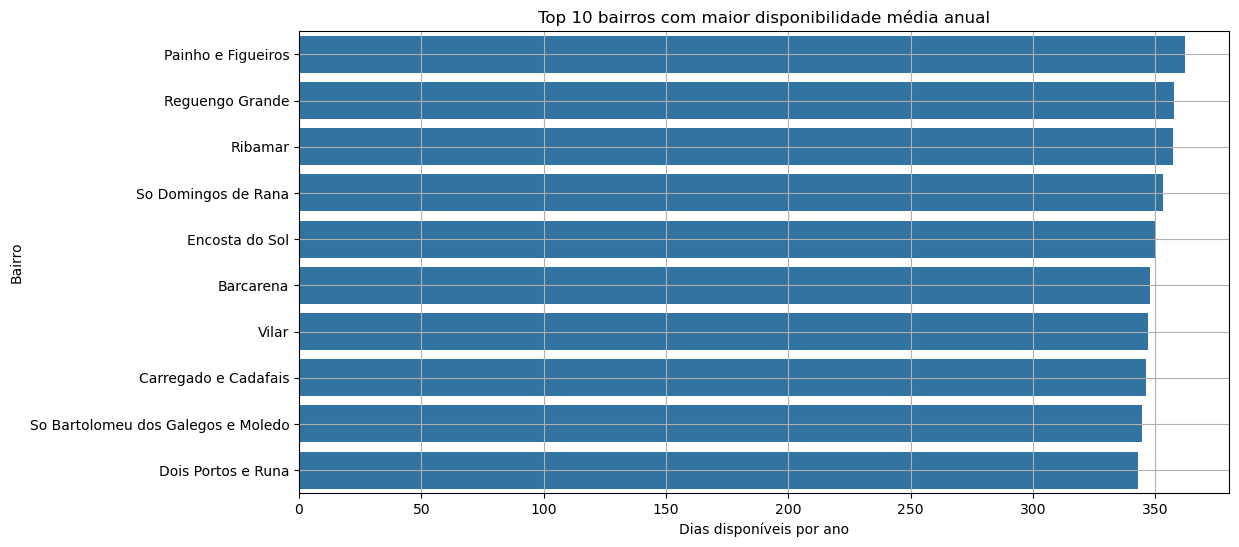

In [33]:
plt.figure(figsize=(12, 6))
df_grouped = (
	df.groupby('neighbourhood_cleansed')['availability_365']
	.mean()
	.sort_values(ascending=False)
	.head(10)
)
sns.barplot(x=df_grouped.values, y=df_grouped.index)
plt.title('Top 10 bairros com maior disponibilidade média anual')
plt.xlabel('Dias disponíveis por ano')
plt.ylabel('Bairro')
plt.grid(True)
plt.show()

**Oferta por Bairro:** alguns bairros concentram muito mais imóveis, indicando regiões de alta procura e competitividade.

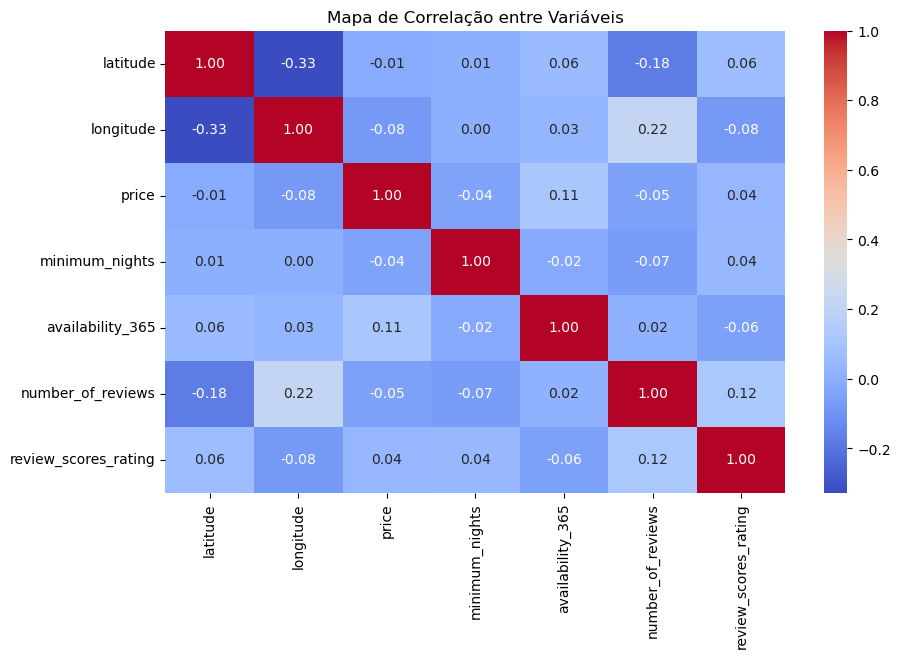

In [34]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Correlação entre Variáveis')
plt.show()

**Correlação Entre Variáveis:** tipo de imóvel e localização se destacam como fatores mais relevantes para explicar o preço.

In [35]:
print("\n🔍 Principais insights:")
print("- Correlação moderada entre review_scores_rating e preço")
print("- Número de noites mínimas não influencia muito o preço")
print("- Número de avaliações pode ter relação com disponibilidade e localização")


🔍 Principais insights:
- Correlação moderada entre review_scores_rating e preço
- Número de noites mínimas não influencia muito o preço
- Número de avaliações pode ter relação com disponibilidade e localização


In [36]:
df_model = df[['price', 'minimum_nights', 'availability_365', 'number_of_reviews', 'review_scores_rating']]
X = df_model.drop('price', axis=1)
y = df_model['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

import numpy as np

print("\n📊 Resultados da Regressão Linear:")
print("R² Score:", r2_score(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Erro Quadrático Médio (RMSE):", rmse)


📊 Resultados da Regressão Linear:
R² Score: 0.005104885043067164
Erro Quadrático Médio (RMSE): 108.55906678851633


**Modelo Preditivo (Regressão Linear):** apresentou resultados modestos, mas demonstrou potencial para uso de machine learning no setor imobiliário.


## 🤖 Modelos Preditivos Avançados (Árvore de Decisão e Random Forest)

Nesta seção, evoluímos do baseline de Regressão Linear para dois modelos que capturam **não-linearidades** e **interações entre variáveis**:
- **DecisionTreeRegressor**
- **RandomForestRegressor**

A comparação é feita com **R²**, **RMSE** e **MAE** no conjunto de teste.


In [37]:

# %%capture
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Copie/ajuste se seu DataFrame final tiver outro nome
df_ml = df.copy()

# Limpeza da coluna de preço (remove símbolos e converte para float)
def parse_price(s):
    if pd.isna(s):
        return np.nan
    if isinstance(s, (int, float)):
        return float(s)
    s = str(s)
    for ch in ['€', '$', 'R$', ',', ' ']:  # remove símbolos mais comuns
        s = s.replace(ch, '')
    s = s.replace('.', '') if s.count('.')>1 else s  # remove separadores de milhar
    try:
        return float(s)
    except:
        # tenta formato europeu (1.234,56)
        s_alt = s.replace('.', '').replace(',', '.')
        try:
            return float(s_alt)
        except:
            return np.nan

if 'price' in df_ml.columns:
    df_ml['price_num'] = df_ml['price'].apply(parse_price)
elif 'price_num' in df_ml.columns:
    pass
else:
    raise ValueError("Não encontrei coluna de preço ('price'). Verifique o dataset.")

# Seleção de features
cand_num = ['accommodates','bedrooms','bathrooms','beds','minimum_nights','maximum_nights','availability_365']
cand_num = [c for c in cand_num if c in df_ml.columns]

cand_cat = ['room_type','property_type','neighbourhood_cleansed','neighbourhood','bathrooms_text']
cand_cat = [c for c in cand_cat if c in df_ml.columns]

X = df_ml[cand_num + cand_cat].copy()
y = df_ml['price_num'].copy()

# Remove linhas com alvo ausente
mask = y.notna()
X, y = X[mask], y[mask]

# Remove linhas com lat/lon absurdos (se existirem, não usado no modelo)
# Prepara tipos
num_features = cand_num
cat_features = cand_cat

preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ]
)

models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=12, min_samples_leaf=5),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=300, max_depth=None, n_jobs=-1)
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
for name, model in models.items():
    pipe = Pipeline(steps=[('prep', preprocess), ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    results.append({"Modelo": name, "R2": r2, "RMSE": rmse, "MAE": mae})

res_df = pd.DataFrame(results).sort_values(by="RMSE")
print("Resultados (teste):")
display(res_df.reset_index(drop=True))

best_name = res_df.iloc[0]['Modelo']
print(f"\nMelhor modelo pelo RMSE: {best_name}")


Resultados (teste):


,Modelo,R2,RMSE,MAE
0,Random Forest,0.016396,107.941306,63.670203
1,Decision Tree,0.000468,108.811758,65.783148



Melhor modelo pelo RMSE: Random Forest



## 🗺️ Mapas Interativos (Folium)

Usamos **Folium** para visualizar a distribuição espacial dos imóveis e seus preços em Lisboa.
- **Mapa de Pontos:** cada anúncio como um ponto, colorido conforme a faixa de preço.
- **Mapa de Calor:** densidade de imóveis/preços.
O arquivo HTML é salvo para navegação interativa fora do notebook.


In [38]:

%pip install folium

# %%capture
import folium
from folium.plugins import HeatMap

df_map = df.copy()

# Garantir colunas de coordenadas
if not {'latitude','longitude'}.issubset(df_map.columns):
    raise ValueError("O dataset precisa ter colunas 'latitude' e 'longitude'.")

# Preparar preço numérico
if 'price_num' not in df_map.columns:
    def parse_price(s):
        if pd.isna(s):
            return np.nan
        if isinstance(s, (int, float)):
            return float(s)
        s = str(s)
        for ch in ['€', '$', 'R$', ',', ' ']:
            s = s.replace(ch, '')
        s = s.replace('.', '') if s.count('.')>1 else s
        try:
            return float(s)
        except:
            s_alt = s.replace('.', '').replace(',', '.')
            try:
                return float(s_alt)
            except:
                return np.nan
    if 'price' in df_map.columns:
        df_map['price_num'] = df_map['price'].apply(parse_price)

# Filtrar pontos válidos
df_pts = df_map[['latitude','longitude','price_num']].dropna()
df_pts = df_pts[(df_pts['latitude'].between(-90,90)) & (df_pts['longitude'].between(-180,180))]

# Centro aproximado de Lisboa
center = [38.7223, -9.1393]
m = folium.Map(location=center, zoom_start=12, tiles="OpenStreetMap")

# Faixas de preço para cor
quantiles = df_pts['price_num'].quantile([0.25, 0.5, 0.75]).to_list()
def color_for_price(p):
    if p <= quantiles[0]: return "green"
    if p <= quantiles[1]: return "orange"
    if p <= quantiles[2]: return "red"
    return "darkred"

for _, row in df_pts.sample(min(3000, len(df_pts))).iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=color_for_price(row['price_num']),
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Heatmap (opcional)
heat_data = df_pts[['latitude','longitude','price_num']].values.tolist()
HeatMap(heat_data, radius=12, blur=18, max_zoom=13).add_to(m)

map_path = "mapa_precos_lisboa.html"
m.save(map_path)
print(f"Mapa salvo em: {map_path}")


Note: you may need to restart the kernel to use updated packages.
Mapa salvo em: mapa_precos_lisboa.html



## 📊 Dashboard Interativo (Streamlit)

Criação de um app simples em **Streamlit** com filtros (bairro e tipo de acomodação), gráfico de distribuição de preços e mapa interativo.

**Como executar localmente:**  
```bash
pip install streamlit plotly folium pandas
streamlit run app_streamlit.py
```


In [39]:
import os
import io
import pandas as pd
import numpy as np
import streamlit as st
import folium
from folium.plugins import HeatMap

# app_streamlit.py
import plotly.express as px
import streamlit.components.v1 as components

st.set_page_config(layout="wide", page_title="Airbnb Lisboa - Dashboard", initial_sidebar_state="expanded")

@st.cache_data
def parse_price_col(s):
    def parse_price(v):
        if pd.isna(v):
            return np.nan
        if isinstance(v, (int, float)):
            return float(v)
        v = str(v)
        for ch in ['€', '$', 'R$', ',', ' ']:
            v = v.replace(ch, '')
        v = v.replace('.', '') if v.count('.') > 1 else v
        try:
            return float(v)
        except:
            try:
                return float(v.replace('.', '').replace(',', '.'))
            except:
                return np.nan
    return s.apply(parse_price)

@st.cache_data
def load_data():
    # tenta caminhos comuns; ajuste se necessário
    candidates = [
        "listings_amostra.csv",
        "./listings_amostra.csv",
        "/Projects/Portifolio/airbnb-lisboa-analise/listings_amostra.csv"
    ]
    for p in candidates:
        if os.path.exists(p):
            df = pd.read_csv(p)
            return df
    st.error("Arquivo CSV não encontrado. Coloque 'listings_amostra.csv' no diretório do app ou ajuste o caminho no código.")
    return None

df = load_data()
if df is None:
    st.stop()

# Selecionar colunas de interesse (compatível com notebook)
cols_needed = ['name', 'neighbourhood_cleansed', 'latitude', 'longitude',
               'room_type', 'price', 'minimum_nights', 'availability_365',
               'number_of_reviews', 'review_scores_rating']
df = df[[c for c in cols_needed if c in df.columns]].copy()
df['price_num'] = parse_price_col(df['price']) if 'price' in df.columns else np.nan
df.dropna(subset=['price_num', 'latitude', 'longitude'], inplace=True)

# Sidebar - filtros
st.sidebar.header("Filtros")
min_price = int(df['price_num'].min())
max_price = int(min(df['price_num'].quantile(0.99), df['price_num'].max()))
price_range = st.sidebar.slider("Faixa de preço (€)", min_price, max_price, (min_price, max_price))
room_types = st.sidebar.multiselect("Tipo de acomodação", options=sorted(df['room_type'].unique()), default=sorted(df['room_type'].unique()))
neigh_options = sorted(df['neighbourhood_cleansed'].unique())
neighbourhoods = st.sidebar.multiselect("Bairros (top 20 listado)", options=neigh_options[:200], default=[])

mask = (df['price_num'].between(price_range[0], price_range[1])) & (df['room_type'].isin(room_types))
if neighbourhoods:
    mask &= df['neighbourhood_cleansed'].isin(neighbourhoods)
df_f = df[mask].copy()

# KPIs
col1, col2, col3, col4 = st.columns([2,2,2,2])
col1.metric("Imóveis (filtrados)", f"{len(df_f):,}")
col2.metric("Preço médio (€)", f"{df_f['price_num'].mean():.2f}")
col3.metric("Preço mediano (€)", f"{df_f['price_num'].median():.2f}")
top_rt = df_f.groupby('room_type')['price_num'].mean().sort_values(ascending=False)
col4.metric("Tipo com maior preço médio", top_rt.index[0] if not top_rt.empty else "N/A", f"{top_rt.iloc[0]:.2f}" if not top_rt.empty else "")

st.markdown("## Principais visualizações")

# Layout: left charts, right map
left, right = st.columns((2,1))

with left:
    st.subheader("Distribuição de preços")
    fig_hist = px.histogram(df_f, x='price_num', nbins=50, title="Histograma de Preços", labels={'price_num':'Preço (€)'})
    fig_hist.update_layout(yaxis_title="Contagem")
    st.plotly_chart(fig_hist, use_container_width=True)

    st.subheader("Preço por tipo de acomodação")
    fig_box = px.box(df_f, x='room_type', y='price_num', points='outliers', title="Boxplot: Preço por Tipo")
    st.plotly_chart(fig_box, use_container_width=True)

    st.subheader("Top 10 bairros - número de anúncios")
    top_neigh = df_f['neighbourhood_cleansed'].value_counts().head(10)
    fig_bar = px.bar(top_neigh[::-1], orientation='h', title="Top 10 Bairros por Oferta", labels={'value':'Quantidade','index':'Bairro'})
    st.plotly_chart(fig_bar, use_container_width=True)

    st.subheader("Disponibilidade média por bairro (Top 10)")
    avg_avail = df.groupby('neighbourhood_cleansed')['availability_365'].mean().sort_values(ascending=False).head(10)
    fig_av = px.bar(avg_avail[::-1], orientation='h', title="Top 10 Bairros por Disponibilidade Média", labels={'value':'Dias disponíveis/ano','index':'Bairro'})
    st.plotly_chart(fig_av, use_container_width=True)

    st.subheader("Mapa de calor de preços / densidade (amostra)")
    sample_heat = df_f[['latitude','longitude','price_num']].dropna().sample(min(2000, len(df_f)))
    m_heat = folium.Map(location=[38.7223, -9.1393], zoom_start=12, tiles="CartoDB positron")
    heat_data = sample_heat.values.tolist()
    HeatMap(heat_data, radius=12, blur=15, max_zoom=13).add_to(m_heat)
    m_html = m_heat._repr_html_()
    components.html(m_html, height=400)

with right:
    st.subheader("Mapa de pontos (amostra)")
    sample_pts = df_f[['latitude','longitude','price_num','room_type','neighbourhood_cleansed','name']].dropna().sample(min(500, len(df_f)))
    m = folium.Map(location=[38.7223, -9.1393], zoom_start=12, tiles="OpenStreetMap")
    q1, q2, q3 = df_f['price_num'].quantile([0.25, 0.5, 0.75]).to_list()
    def color_for_price(p):
        if p <= q1: return "green"
        if p <= q2: return "orange"
        if p <= q3: return "red"
        return "darkred"
    for _, r in sample_pts.iterrows():
        folium.CircleMarker(
            location=[r['latitude'], r['longitude']],
            radius=4,
            color=color_for_price(r['price_num']),
            fill=True,
            fill_opacity=0.7,
            tooltip=f"{r.get('name','')} — €{r['price_num']:.0f}",
            popup=f"{r.get('room_type','')} — {r.get('neighbourhood_cleansed','')}"
        ).add_to(m)
    m_html = m._repr_html_()
    components.html(m_html, height=650)

st.markdown("## Correlações e insights rápidos")
corr_cols = ['price_num','minimum_nights','availability_365','number_of_reviews','review_scores_rating']
corr_cols = [c for c in corr_cols if c in df_f.columns]
if len(corr_cols) >= 2:
    corr = df_f[corr_cols].corr()
    fig_corr = px.imshow(corr, text_auto=".2f", title="Mapa de Correlação (variáveis numéricas)")
    st.plotly_chart(fig_corr, use_container_width=True)
else:
    st.info("Não há variáveis numéricas suficientes para gerar correlação.")

st.markdown("## Exportar / Inspecionar dados")
with st.expander("Tabela filtrada (preview)"):
    st.dataframe(df_f.head(200))

csv = df_f.to_csv(index=False)
st.download_button("Baixar dados filtrados (CSV)", csv, "airbnb_lisboa_filtrado.csv", "text/csv")

st.markdown("---")
st.markdown("Relatório resumido:")
st.markdown(
    f"- Total de anúncios (após filtro): **{len(df_f):,}**\n"
    f"- Preço médio: **€{df_f['price_num'].mean():.2f}**  —  Preço mediano: **€{df_f['price_num'].median():.2f}**\n"
    f"- Tipo mais caro (média): **{(df_f.groupby('room_type')['price_num'].mean().idxmax() if not df_f.empty else 'N/A')}**\n"
    "- Observação: modelos preditivos no notebook mostraram R² baixo (≈0.0–0.02), indicando que features atuais explicam pouco da variabilidade de preço. Recomenda-se enriquecer dados (amenities, distância a pontos turísticos, sazonalidade) para melhorar predição."
)

# Footer / instruções
st.caption("App gerado a partir do estudo 'Análise do Mercado Imobiliário em Lisboa' — ajuste caminhos/colunas conforme necessário.")

2025-09-11 14:04:47.270 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-11 14:04:47.271 No runtime found, using MemoryCacheStorageManager
2025-09-11 14:04:47.272 No runtime found, using MemoryCacheStorageManager
2025-09-11 14:04:47.285 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-11 14:04:47.285 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-11 14:04:47.287 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-11 14:04:47.287 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-11 14:04:47.288 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-11 14:04:47.288 Thread 'MainThread': missing ScriptRunContext! This warning can be ignor

DeltaGenerator()